# Binary survival analysis
In this notebook, we binarize the Cox Model analysis, with predicting 2 things :
- If a patient will die (1) or not (0).
- If the patient's disease will progress (1) or not (0).

We use the data from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163 

## Notebook plan :
1. Reading the dataset
2. Classify for a given t
3. Classify for some values of t

In [24]:
import pandas as pd
import numpy as np
from models.BinarySurvival import BinarySurvival
from sklearn.linear_model import LogisticRegression
from utils.preProcessing import preProcessing
import matplotlib.pyplot as plt

In [25]:
model = LogisticRegression()
binary_clf = BinarySurvival(model)
preprocessor = preProcessing()

## 1. Reading dataset
We read the S1 table from the article, and we keep only naive patients.

In [26]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = preprocessor.filter_column(df, "Cohort", "Naive")
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


## 2. Train and predict the binary classifier, for an arbitrary t
For now, we test an arbitrary t (for example, the median). The features we are focused on are : 
- CD8+ T cell score
- Exome mut per mb
- Genome mut per mb
- M1M2 expression
- CD274 expression
- Age at advanced diagnosis

### a. Progression prediction
We want to predict if the patient's disease will progress (1) or not (0). So we consider the Time To Progression (TTP) and the Progression_1 columns for labellisation.

In [27]:
X_ttp = df.loc[:,["CD8+ T cell score","Exome mut per mb","Genome mut per mb","M1M2 expression","CD274 expression","Age at advanced disease diagnosis"]].to_numpy()
status_ttp = df["Progression_1"].to_numpy()
time_ttp = df["Time to progression (days)"].to_numpy()
t_ttp = np.median(time_ttp)

#### i. Delete non analyzable patients
The patients which have status = 0 and time < t are not analyzable, because we don't know what will happen betweet time and t. So we don't consider them.

In [28]:
to_drop_ttp = binary_clf.drop_non_analyzable_patients(status_ttp, time_ttp, t_ttp)
print(f"Number of patients deleted : {to_drop_ttp.shape[0]} of {X_ttp.shape[0]}")
X_ttp, status_ttp, time_ttp = np.delete(X_ttp, to_drop_ttp,axis=0), np.delete(status_ttp, to_drop_ttp), np.delete(time_ttp, to_drop_ttp)

Number of patients deleted : 6 of 82


#### ii. Label patients
Now, we affect a class label to patients (1 if the disease will progress, 0 otherwise).

In [29]:
y_ttp = binary_clf.label_patients(time_ttp, t_ttp)
y_ttp

array([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0])

#### iii. Train the classifier and predict
We use the leave one out cross validation.

In [30]:
y_pred_ttp, y_score_ttp = binary_clf.leave_one_out_cross_validation(X_ttp, y_ttp)

### b. Surviving prediction
We want to predict if the patient will die (1) or not (0). So we consider the Overall Survival (OS) and Alive_0 columns for labellisation. 

In [31]:
X_os = df.loc[:,["CD8+ T cell score","Exome mut per mb","Genome mut per mb","M1M2 expression","CD274 expression","Age at advanced disease diagnosis"]].to_numpy()
status_os = df["Alive_0"].to_numpy()
time_os = df["Overall survival (days)"].to_numpy()
t_os = np.median(time_os)

#### i. Delete non analyzable patients.

In [32]:
to_drop_os = binary_clf.drop_non_analyzable_patients(status_os, time_os, t_os)
print(f"Number of patients deleted : {to_drop_os.shape[0]} of {X_os.shape[0]}")
X_os, status_os, time_os = np.delete(X_os, to_drop_os,axis=0), np.delete(status_os, to_drop_os), np.delete(time_os, to_drop_os)

Number of patients deleted : 1 of 82


#### ii. Label patients

In [33]:
y_os = binary_clf.label_patients(time_os, t_os)
y_os

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

#### iii. Train the classifier and predict
Leave one out cross validation again

In [34]:
y_pred_os, y_score_os = binary_clf.leave_one_out_cross_validation(X_os, y_os)

### c. Evaluate the predictions

#### i. Accuracy, Precision, Recall, F1-score

In [35]:
# TTP :
acc_ttp, pre_ttp, rec_ttp, f1_ttp = binary_clf.eval_metrics_from_conf_matrix(y_ttp, y_pred_ttp)
print("TTP : ")
print(f"Accuracy : {acc_ttp}")
print(f"Precision : {pre_ttp}")
print(f"Recall : {rec_ttp}")
print(f"F1-score : {f1_ttp}\n")

# OS :
acc_os, pre_os, rec_os, f1_os = binary_clf.eval_metrics_from_conf_matrix(y_os, y_pred_os)
print("OS : ")
print(f"Accuracy : {acc_os}")
print(f"Precision : {pre_os}")
print(f"Recall : {rec_os}")
print(f"F1-score : {f1_os}")

TTP : 
Accuracy : 0.59
Precision : 0.55
Recall : 0.63
F1-score : 0.59

OS : 
Accuracy : 0.49
Precision : 0.49
Recall : 0.6
F1-score : 0.54


#### ii. ROC curve and AUC

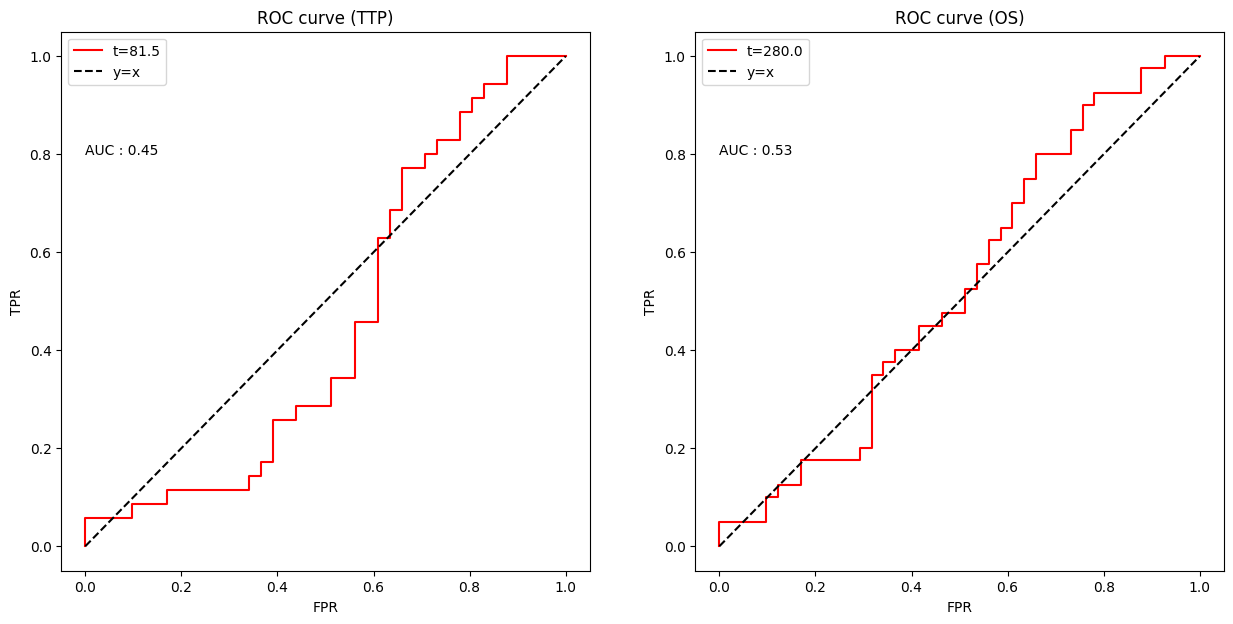

In [36]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
x = np.linspace(0,1,100)

# TTP :
FPR_ttp, TPR_ttp, thresholds_ttp = binary_clf.compute_roc_curve(y_ttp, y_score_ttp) 
auc_ttp = binary_clf.compute_auc(y_ttp, y_score_ttp)
ax[0].plot(FPR_ttp, TPR_ttp, color='red',label=f't={t_ttp}')
ax[0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC curve (TTP)')
ax[0].legend()
ax[0].text(0,0.8,f"AUC : {auc_ttp}")

# OS :
FPR_os, TPR_os, thresholds_os = binary_clf.compute_roc_curve(y_os, y_score_os) 
auc_os = binary_clf.compute_auc(y_os, y_score_os)
ax[1].plot(FPR_os, TPR_os, color='red',label=f't={t_os}')
ax[1].plot(x,x,linestyle='--',color='black',label='y=x')
ax[1].set_xlabel('FPR')
ax[1].set_ylabel('TPR')
ax[1].set_title('ROC curve (OS)')
ax[1].legend()
ax[1].text(0,0.8,f"AUC : {auc_os}")

plt.savefig('ROC-curve-fixed-t.png')

## 3. Train and test for different values of t
We'll test different values of t, per quantile (Q).

In [37]:
Q = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [38]:
def pipeline_binary_classifier(X, status, time, t_values):
    """ 
    Make the pipeline labellisation - train - evaluation for each value of t_values.

    ### Parameters :
    - X (n_samples, n_features) : the features of each patient.
    - status : the event status for each patient (1 if event observed, 0 otherwise)
    - time : the time of the event (if no event observed, time = censoring time)
    - t_values : the values of t tested

    ### Returns :
    - The accuracy, precision, recall, f1-score for each value of t
    - The ROC curve for each value of t
    - The AUC value for each value of t
    """
    acc_values, pre_values, rec_values, f1_values, FPR_values, TPR_values, auc_values, to_drop_values = [],[],[],[],[],[],[], []

    for t in t_values:
        X_copy, status_copy, time_copy = X, status, time

        # 1. Delete non analyzable patients :
        to_drop = binary_clf.drop_non_analyzable_patients(status_copy, time_copy, t)
        X_copy, status_copy, time_copy = np.delete(X_copy, to_drop,axis=0), np.delete(status_copy, to_drop), np.delete(time_copy, to_drop)

        # 2. Label patients :
        y = binary_clf.label_patients(time_copy, t)

        # 3. Train and predict : leave one out cross validation
        y_pred, y_score = binary_clf.leave_one_out_cross_validation(X_copy, y)

        # 4. Evaluation :
        acc, pre, rec, f1 = binary_clf.eval_metrics_from_conf_matrix(y, y_pred)
        FPR, TPR, thresholds = binary_clf.compute_roc_curve(y, y_score) 
        auc = binary_clf.compute_auc(y, y_score)

        # 5. Add to memory
        acc_values.append(acc)
        pre_values.append(pre)
        rec_values.append(rec)
        f1_values.append(f1)
        FPR_values.append(FPR)
        TPR_values.append(TPR)
        auc_values.append(auc)
        to_drop_values.append(np.round(to_drop.shape[0]/X.shape[0],2))

    return acc_values, pre_values, rec_values, f1_values, FPR_values, TPR_values, auc_values, to_drop_values

def plot_roc_for_each_t(FPR_values, TPR_values, t_values, filename):
    """ 
    Plot the ROC curve for each value of t
    """
    fig, ax = plt.subplots(figsize=(10,7))
    x = np.linspace(0,1,100)
    ax.plot(x,x,linestyle='--',color='black',label='y=x')
    for i in range(len(t_values)):
        ax.plot(FPR_values[i], TPR_values[i],label=f't={t_values[i]}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title('ROC curve')
    plt.legend()
    plt.savefig(filename)

def compare_metrics(acc_values, pre_values, rec_values, auc_values, f1_values, to_drop_values, t_values, filename):
    """
    
    """
    fig, ax = plt.subplots(3,2,figsize=(15,15))

    ax[0,0].barh([str(t) for t in t_values],acc_values)
    ax[0,0].set_xlabel("Accuracy")
    ax[0,0].set_ylabel("t")
    ax[0,0].set_title("Accuracy for different t")

    ax[0,1].barh([str(t) for t in t_values],pre_values)
    ax[0,1].set_xlabel("Precision")
    ax[0,1].set_ylabel("t")
    ax[0,1].set_title("Precision for different t")

    ax[1,0].barh([str(t) for t in t_values],rec_values)
    ax[1,0].set_xlabel("Recall")
    ax[1,0].set_ylabel("t")
    ax[1,0].set_title("Recall for different t")

    ax[1,1].barh([str(t) for t in t_values],f1_values)
    ax[1,1].set_xlabel("F1-score")
    ax[1,1].set_ylabel("t")
    ax[1,1].set_title("F1-score for different t")

    ax[2,0].barh([str(t) for t in t_values],auc_values)
    ax[2,0].set_xlabel("AUC")
    ax[2,0].set_ylabel("t")
    ax[2,0].set_title("AUC for different t")

    ax[2,1].barh([str(t) for t in t_values],to_drop_values)
    ax[2,1].set_xlabel("Proportion of deleted patients")
    ax[2,1].set_ylabel("t")
    ax[2,1].set_title("Proportion of deleted patients for different t")

    plt.savefig(filename)

### a. Predict progression (TTP)

In [39]:
t_values_ttp = [np.quantile(time_ttp, q) for q in Q]

#### i. Binary classifier pipeline
Labellisation, train-test, evaluation

In [40]:
acc_values_ttp, pre_values_ttp, rec_values_ttp, f1_values_ttp, FPR_values_ttp, TPR_values_ttp, auc_values_ttp, to_drop_values_ttp = pipeline_binary_classifier(X_ttp, status_ttp, time_ttp, t_values_ttp)

#### ii. Plot evaluation metrics

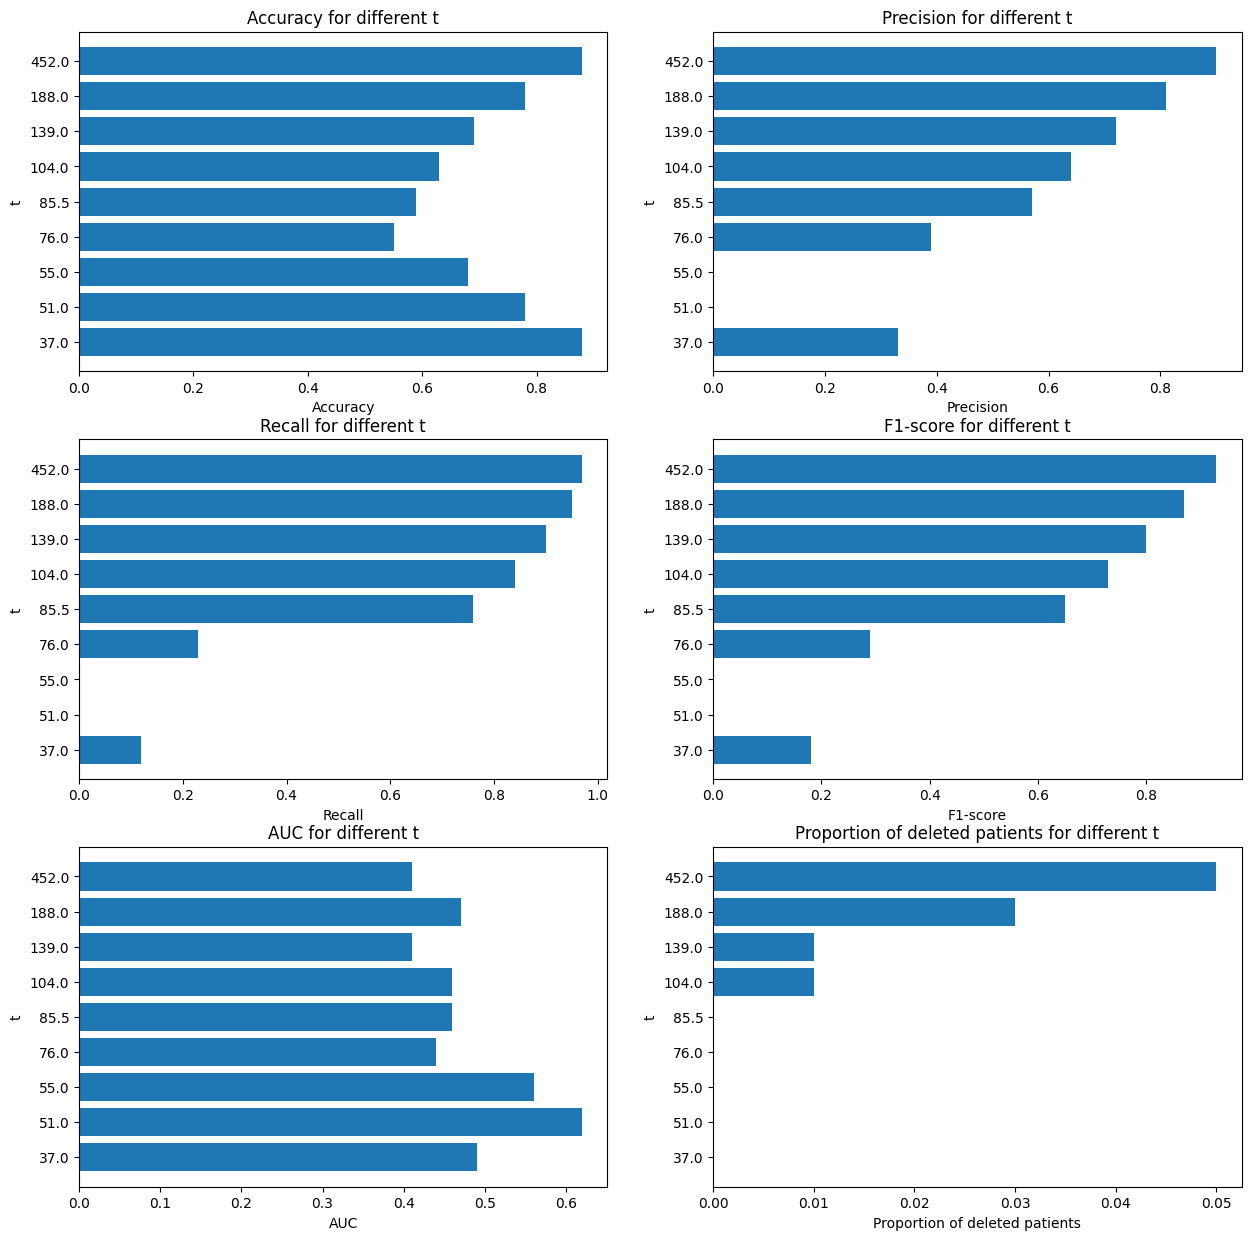

In [41]:
# From confusion matrix :
compare_metrics(acc_values_ttp, pre_values_ttp, rec_values_ttp, auc_values_ttp, f1_values_ttp, to_drop_values_ttp, t_values_ttp, "TTP.png")

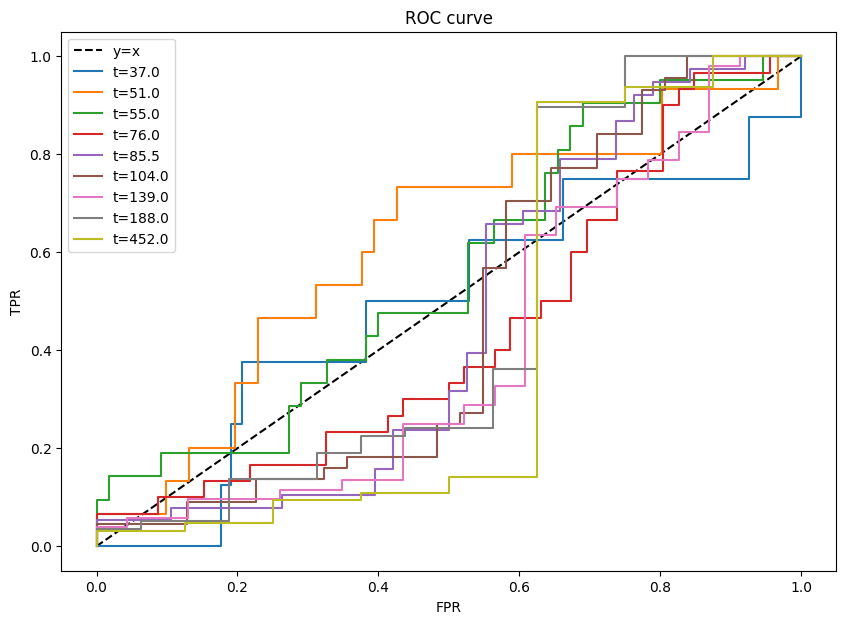

In [42]:
# ROC curve
plot_roc_for_each_t(FPR_values_ttp, TPR_values_ttp, t_values_ttp, "ROC-ttp.png")

### b. Predict surviving (OS)

In [43]:
t_values_os = [np.quantile(time_os, q) for q in Q]

#### i. Binary classifier pipeline
Labellisation, train-test, evaluation

In [44]:
acc_values_os, pre_values_os, rec_values_os, f1_values_os, FPR_values_os, TPR_values_os, auc_values_os, to_drop_values_os = pipeline_binary_classifier(X_os, status_os, time_os, t_values_os)

#### ii. Plot evaluation metrics

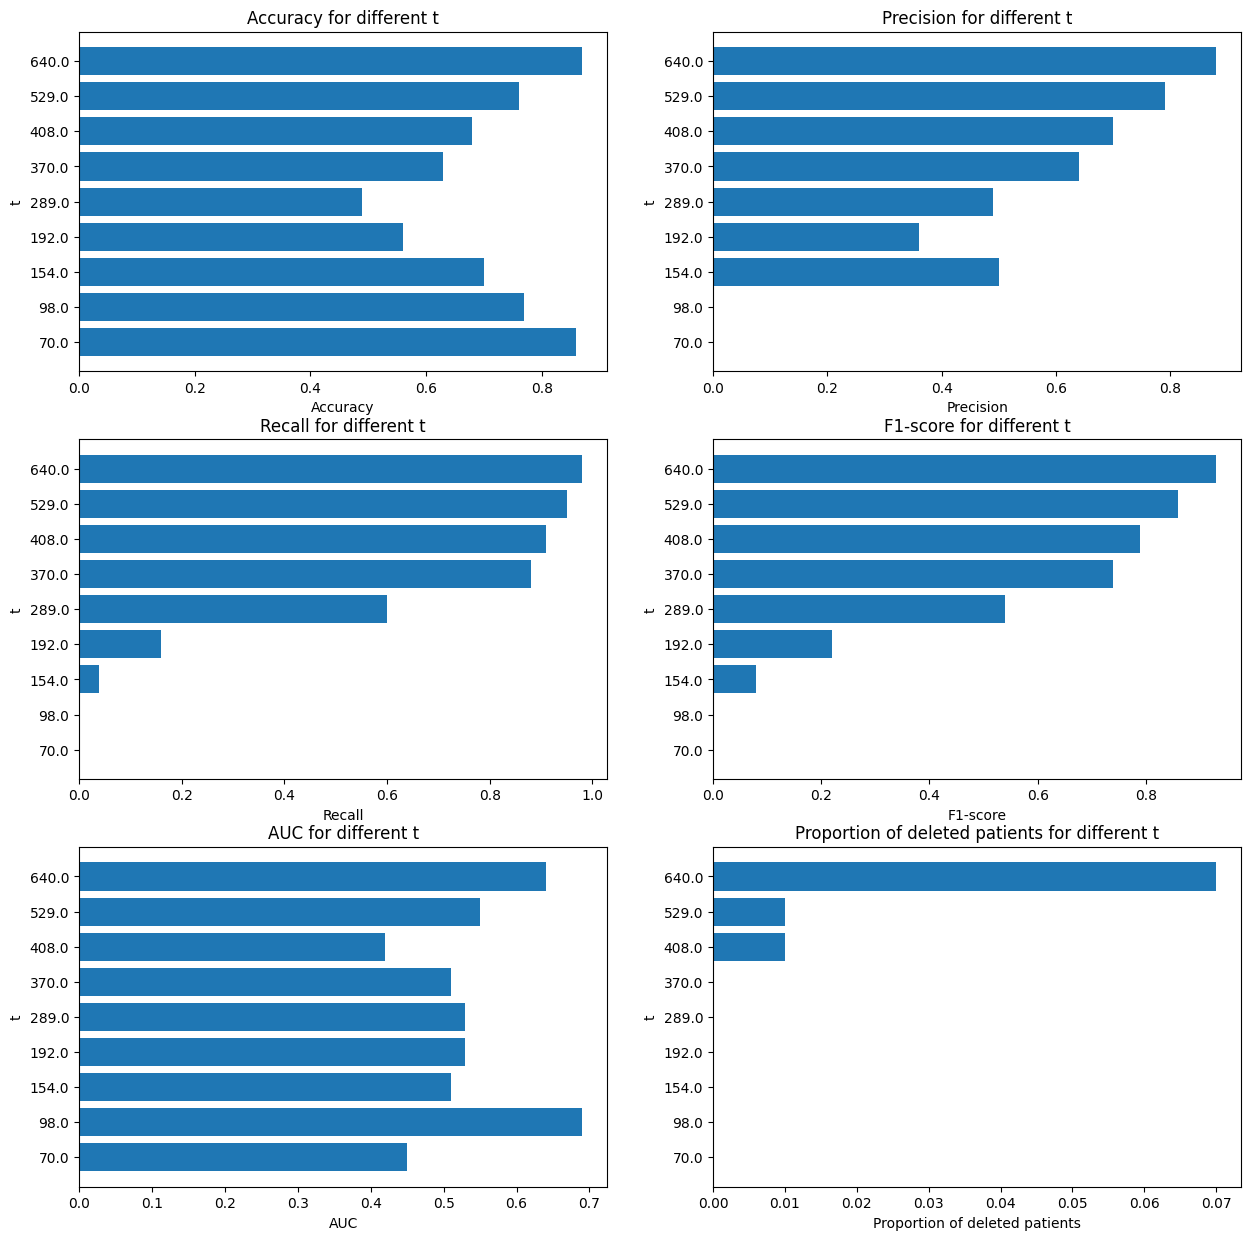

In [45]:
# From confusion matrix :
compare_metrics(acc_values_os, pre_values_os, rec_values_os, auc_values_os, f1_values_os, to_drop_values_os, t_values_os, "OS.png")

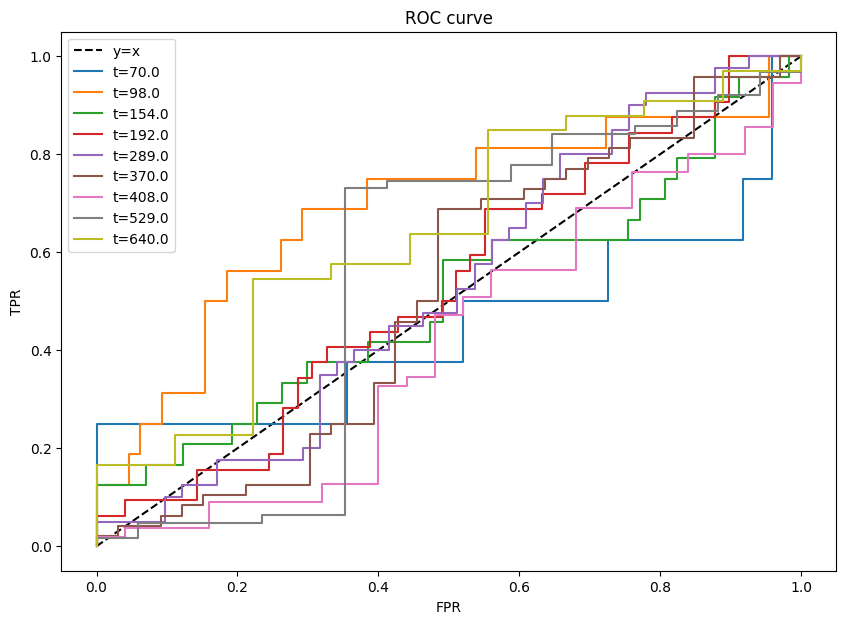

In [46]:
# ROC curve
plot_roc_for_each_t(FPR_values_os, TPR_values_os, t_values_os, "ROC-os.png")